In [1]:
# Import public packages and functions
import os
import pandas as pd
import numpy as np
import sys
import json
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp

# inserting the lib folder to the compiler
sys.path.insert(0, './lib')
sys.path.insert(0, './utils/')

import utils_plotting_accelerometer, utils_accelerometer, utils_misc

from lib_accelerometer import ACCELEROMETER 
from lib_data import DATA_IO
from lib_statistics import NON_PARAMETRIC_TEST

In [2]:
PATH_CURR   = os.path.abspath(os.curdir)    # current code
PATH        = (str(Path(PATH_CURR).parent)) # data repository: upper directory where datasets situated
PATH_DATA   = PATH + "\\data"               # the recordings data directory
PATH_EVENTS = PATH + "\\events"
SUB_LIST    = utils_misc.get_SUB_list(PATH_DATA) # get the SUB id list which we have a recording of them

# 1. Load accelerometer event history of all patient
df_accelerometer_events = pd.read_csv(DATA_IO.path_events_dataframe + "EVENTS_ACC.csv")

# 2. accelerometer events
accelerometer_events    = {} 

In [3]:
for SUB in SUB_LIST: 
    
    patient_kinematics = ACCELEROMETER(PATH, SUB)
    patient_events     = df_accelerometer_events[df_accelerometer_events.patient==int(SUB)]
    patient_acc_events = utils_accelerometer.create_accelerometer_event_dictionary(patient_events,  patient_kinematics, 
                                                                                    patient_kinematics.fs, t_observation=4)

    # If the accelerometer events dictionary is empty assign the patient event dictionary to it
    if(len(accelerometer_events)==0):
        accelerometer_events = patient_acc_events

    # otherwise, merge previous patient events with current patient events 
    else:
        accelerometer_events = utils_misc.combine_dictionaries(accelerometer_events, patient_acc_events)

... pickle loading: C:\Users\a.kaymak\Desktop\Papers\2025 Parkinson STN-DBS Dyskinesia LFP-ECG\files\data\sub-008\008_mergedData_v4.0_acc_right.P
... pickle loading: C:\Users\a.kaymak\Desktop\Papers\2025 Parkinson STN-DBS Dyskinesia LFP-ECG\files\data\sub-008\008_mergedData_v4.0_acc_left.P
... pickle loading: C:\Users\a.kaymak\Desktop\Papers\2025 Parkinson STN-DBS Dyskinesia LFP-ECG\files\data\sub-009\009_mergedData_v4.0_acc_right.P
... pickle loading: C:\Users\a.kaymak\Desktop\Papers\2025 Parkinson STN-DBS Dyskinesia LFP-ECG\files\data\sub-009\009_mergedData_v4.0_acc_left.P
... pickle loading: C:\Users\a.kaymak\Desktop\Papers\2025 Parkinson STN-DBS Dyskinesia LFP-ECG\files\data\sub-010\010_mergedData_v4.0_acc_right.P

	...correct tasks in C:\Users\a.kaymak\Desktop\Papers\2025 Parkinson STN-DBS Dyskinesia LFP-ECG\files\data\sub-010\010_mergedData_v4.0_acc_right.P
... pickle loading: C:\Users\a.kaymak\Desktop\Papers\2025 Parkinson STN-DBS Dyskinesia LFP-ECG\files\data\sub-010\010_merged

# 1. Plot Event Categories

<Figure size 640x480 with 0 Axes>

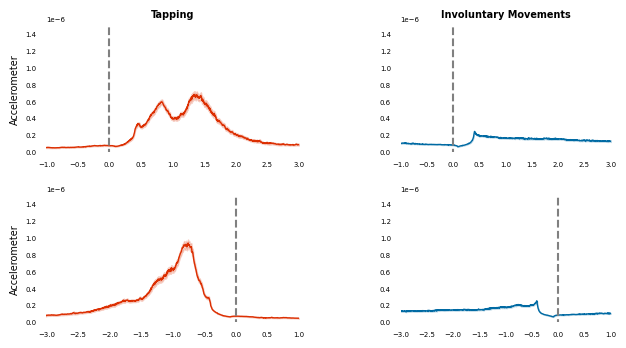

In [4]:
utils_plotting_accelerometer.plot_accelerometer_events_by_category(accelerometer_events, patient_kinematics, colors = utils_plotting_accelerometer.colors, 
                                                                   figure_name = DATA_IO.path_figure +"SUB" + str(SUB) +"accelerometer_events")

## 1.1 Voluntary Tapping

<Figure size 640x480 with 0 Axes>

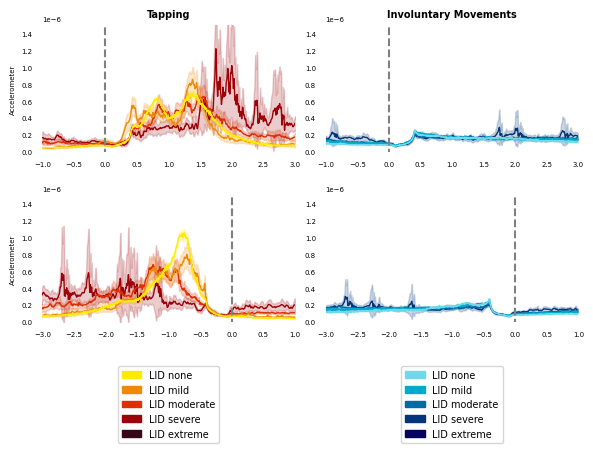

In [5]:
utils_plotting_accelerometer.plot_accelerometer_events_by_dyskinesia(accelerometer_events, patient_kinematics, colors = utils_plotting_accelerometer.colors, 
                                                                     figure_name = DATA_IO.path_figure +"SUB" + str(SUB) +"accelerometer_events_per_dyskinesia_severity")

# 2. Extract Temporal Metrics for Event Segments

In [6]:
df_accelerometer_features = pd.DataFrame()

for SUB in SUB_LIST: 
    # get individual patient kinematics and corresponding events
    patient_kinematics = ACCELEROMETER(PATH, SUB)
    patient_events     = df_accelerometer_events[df_accelerometer_events.patient==int(SUB)]
    # extract 
    df_patient_accelerometer_features, feat_temporal = patient_kinematics.extract_temporal_metrics_from_event_segments(patient=SUB, event_dataframe=patient_events)

    if(len(df_accelerometer_features)==0): # if the dataframe is empty
        df_accelerometer_features = df_patient_accelerometer_features
    else:
        df_accelerometer_features = pd.concat([df_accelerometer_features, df_patient_accelerometer_features], ignore_index=True)


... pickle loading: C:\Users\a.kaymak\Desktop\Papers\2025 Parkinson STN-DBS Dyskinesia LFP-ECG\files\data\sub-008\008_mergedData_v4.0_acc_right.P
... pickle loading: C:\Users\a.kaymak\Desktop\Papers\2025 Parkinson STN-DBS Dyskinesia LFP-ECG\files\data\sub-008\008_mergedData_v4.0_acc_left.P
... pickle loading: C:\Users\a.kaymak\Desktop\Papers\2025 Parkinson STN-DBS Dyskinesia LFP-ECG\files\data\sub-009\009_mergedData_v4.0_acc_right.P
... pickle loading: C:\Users\a.kaymak\Desktop\Papers\2025 Parkinson STN-DBS Dyskinesia LFP-ECG\files\data\sub-009\009_mergedData_v4.0_acc_left.P
... pickle loading: C:\Users\a.kaymak\Desktop\Papers\2025 Parkinson STN-DBS Dyskinesia LFP-ECG\files\data\sub-010\010_mergedData_v4.0_acc_right.P

	...correct tasks in C:\Users\a.kaymak\Desktop\Papers\2025 Parkinson STN-DBS Dyskinesia LFP-ECG\files\data\sub-010\010_mergedData_v4.0_acc_right.P
... pickle loading: C:\Users\a.kaymak\Desktop\Papers\2025 Parkinson STN-DBS Dyskinesia LFP-ECG\files\data\sub-010\010_merged

## 2.1 Comparison Between Tappping vs Involuntary Movements

In [7]:
kw_test   = NON_PARAMETRIC_TEST.kruskall_wallis(df_accelerometer_features, group_variable="event_category", 
                                                feature_set=feat_temporal, subset_variable="event_segment")

dunn_test = NON_PARAMETRIC_TEST.dunn_test(df_accelerometer_features, group_variable="event_category", 
                                          feature_set=feat_temporal, subset_variable="event_segment")

C:\Users\a.kaymak\Anaconda3\lib\site-packages\pingouin\nonparametric.py:563: RuntimeWarning: invalid value encountered in double_scalars
  H /= scipy.stats.tiecorrect(data["rank"].to_numpy())
C:\Users\a.kaymak\Anaconda3\lib\site-packages\scikit_posthocs\_posthocs.py:340: RuntimeWarning: invalid value encountered in double_scalars
  z_value = diff / np.sqrt((A - x_ties) * B)


## 2.2 Comparison for Tapping Between Different Dyskinesia Severity Scores

In [8]:
kw_test_tapping   = NON_PARAMETRIC_TEST.kruskall_wallis(df_accelerometer_features[df_accelerometer_features.event_category=="tapping"], 
                                                        group_variable="dyskinesia_severity", 
                                                        feature_set=feat_temporal, subset_variable="event_segment")

dunn_test_tapping = NON_PARAMETRIC_TEST.dunn_test(df_accelerometer_features[df_accelerometer_features.event_category=="tapping"], 
                                                  group_variable="dyskinesia_severity", 
                                                  feature_set=feat_temporal, subset_variable="event_segment")

C:\Users\a.kaymak\Anaconda3\lib\site-packages\pingouin\nonparametric.py:563: RuntimeWarning: invalid value encountered in double_scalars
  H /= scipy.stats.tiecorrect(data["rank"].to_numpy())
C:\Users\a.kaymak\Anaconda3\lib\site-packages\pingouin\nonparametric.py:563: RuntimeWarning: invalid value encountered in double_scalars
  H /= scipy.stats.tiecorrect(data["rank"].to_numpy())
C:\Users\a.kaymak\Anaconda3\lib\site-packages\scikit_posthocs\_posthocs.py:340: RuntimeWarning: invalid value encountered in double_scalars
  z_value = diff / np.sqrt((A - x_ties) * B)
C:\Users\a.kaymak\Anaconda3\lib\site-packages\scikit_posthocs\_posthocs.py:340: RuntimeWarning: invalid value encountered in double_scalars
  z_value = diff / np.sqrt((A - x_ties) * B)


## 2.3 Comparison for Involuntary Movement Between Different Dyskinesia Severity Scores

In [9]:
kw_test_involuntary_move = NON_PARAMETRIC_TEST.kruskall_wallis(df_accelerometer_features[df_accelerometer_features.event_category=="involuntary_movement"], 
                                                               group_variable="dyskinesia_severity", 
                                                               feature_set=feat_temporal, subset_variable="event_segment")

dunn_test_involuntary_move = NON_PARAMETRIC_TEST.dunn_test(df_accelerometer_features[df_accelerometer_features.event_category=="involuntary_movement"], 
                                                           group_variable="dyskinesia_severity", 
                                                           feature_set=feat_temporal, subset_variable="event_segment")

C:\Users\a.kaymak\Anaconda3\lib\site-packages\pingouin\nonparametric.py:563: RuntimeWarning: invalid value encountered in double_scalars
  H /= scipy.stats.tiecorrect(data["rank"].to_numpy())
C:\Users\a.kaymak\Anaconda3\lib\site-packages\scikit_posthocs\_posthocs.py:340: RuntimeWarning: invalid value encountered in double_scalars
  z_value = diff / np.sqrt((A - x_ties) * B)


In [35]:
x = [df_accelerometer_features[(df_accelerometer_features.event_segment=="event") &
                               (df_accelerometer_features.event_category=="tapping") &
                               (df_accelerometer_features.dyskinesia_severity=="LID_none")].duration.to_list(),
     df_accelerometer_features[(df_accelerometer_features.event_segment=="event") &
                               (df_accelerometer_features.event_category=="tapping") &
                               (df_accelerometer_features.dyskinesia_severity=="LID_mild")].duration.to_list(),
     df_accelerometer_features[(df_accelerometer_features.event_segment=="event") &
                               (df_accelerometer_features.event_category=="tapping") &
                               (df_accelerometer_features.dyskinesia_severity=="LID_moderate")].duration.to_list(),
     df_accelerometer_features[(df_accelerometer_features.event_segment=="event") &
                               (df_accelerometer_features.event_category=="tapping") &
                               (df_accelerometer_features.dyskinesia_severity=="LID_severe")].duration.to_list()]

In [37]:
df_accelerometer_features[(df_accelerometer_features.event_segment=="event") &
                               (df_accelerometer_features.event_category=="tapping") &
                               (df_accelerometer_features.dyskinesia_severity=="LID_none")].duration.median()

1.349609375

In [38]:
df_accelerometer_features[(df_accelerometer_features.event_segment=="event") &
                               (df_accelerometer_features.event_category=="tapping") &
                               (df_accelerometer_features.dyskinesia_severity=="LID_mild")].duration.median()

1.234375

In [36]:
sp.posthoc_dunn(x, p_adjust = 'holm')

,1,2,3,4
1,1.000000e+00,4.472929e-05,2.934696e-22,1.874773e-13
2,4.472929e-05,1.000000e+00,7.142897e-26,1.550586e-16
3,2.934696e-22,7.142897e-26,1.000000e+00,2.941685e-05
4,1.874773e-13,1.550586e-16,2.941685e-05,1.000000e+00


In [17]:
dunn_test_tapping[(dunn_test_tapping.feature == "duration") & (dunn_test_tapping.event_segment == "event")]

,event_segment,feature,group1,group2,pvalue
192,event,duration,LID_mild,LID_moderate,7.142897e-26
193,event,duration,LID_mild,LID_none,4.472929e-05
194,event,duration,LID_mild,LID_severe,1.550586e-16
195,event,duration,LID_moderate,LID_mild,7.142897e-26
196,event,duration,LID_moderate,LID_none,2.934696e-22
197,event,duration,LID_moderate,LID_severe,2.941685e-05
198,event,duration,LID_none,LID_mild,4.472929e-05
199,event,duration,LID_none,LID_moderate,2.934696e-22
200,event,duration,LID_none,LID_severe,1.874773e-13
201,event,duration,LID_severe,LID_mild,1.550586e-16


In [42]:
feat_temporal

['duration',
 'mean',
 'std',
 'RMS',
 'range',
 'median',
 'iqr',
 'peak',
 'peak_location',
 'mean_crossing_rate',
 'signal_energy',
 'signal_magnitude_area',
 'crest_factor',
 'impulse_factor',
 'shape_factor',
 'clearance_factor']

In [41]:
dunn_test_tapping[(dunn_test_tapping.event_segment == "event")]

,event_segment,feature,group1,group2,pvalue
192,event,duration,LID_mild,LID_moderate,7.142897e-26
193,event,duration,LID_mild,LID_none,4.472929e-05
194,event,duration,LID_mild,LID_severe,1.550586e-16
195,event,duration,LID_moderate,LID_mild,7.142897e-26
196,event,duration,LID_moderate,LID_none,2.934696e-22
...,...,...,...,...,...
379,event,clearance_factor,LID_none,LID_moderate,8.268861e-01
380,event,clearance_factor,LID_none,LID_severe,4.622802e-07
381,event,clearance_factor,LID_severe,LID_mild,7.768746e-12
382,event,clearance_factor,LID_severe,LID_moderate,6.522010e-07


# 3. Figure Generation

In [11]:
def boxplot(data, feat_x, feat_y, hue, axis, color_palette, ylabel):
    axis = sns.boxplot(data=data, x=feat_x, y=feat_y, hue=hue, palette= color_palette, showfliers=False, ax=axis, legend=False)
    axis.set_xlabel("")
    axis.set_ylabel(ylabel, fontsize=utils_plotting_accelerometer.LABEL_SIZE)
    axis.legend(loc="lower center", fontsize=utils_plotting_accelerometer.LABEL_SIZE, 
                bbox_to_anchor=(0.5, -0.6), title=None, ncol=2, frameon=False)
    return axis

def count_plot(data, feat_x, hue, axis, color_palette):
    axis = sns.countplot(data, x=feat_x, hue=hue, orient="h", palette=color_palette, ax=axis)
    axis.set_xlabel("")
    axis.set_title(feat_x, fontsize=utils_plotting_accelerometer.LABEL_SIZE, weight="bold")
    axis.legend(loc="lower center", fontsize=utils_plotting_accelerometer.LABEL_SIZE, 
                bbox_to_anchor=(0.5, -0.5), title=None, ncol=2, frameon=False)
    return axis

In [12]:
colors_tapping  = [utils_plotting_accelerometer.colors["tapping"]['none'],
                   utils_plotting_accelerometer.colors["tapping"]['mild'],
                   utils_plotting_accelerometer.colors["tapping"]['moderate'],
                   utils_plotting_accelerometer.colors["tapping"]['severe']]

colors_invol_m  = [utils_plotting_accelerometer.colors["involuntary_movement"]['none'],
                   utils_plotting_accelerometer.colors["involuntary_movement"]['mild'],
                   utils_plotting_accelerometer.colors["involuntary_movement"]['moderate'],
                   utils_plotting_accelerometer.colors["involuntary_movement"]['severe']]

colors_category = [utils_plotting_accelerometer.colors["tapping"]['moderate'],
                   utils_plotting_accelerometer.colors["involuntary_movement"]['moderate']]

In [57]:
feat_temporal

['duration',
 'mean',
 'std',
 'RMS',
 'range',
 'median',
 'iqr',
 'peak',
 'peak_location',
 'mean_crossing_rate',
 'signal_energy',
 'signal_magnitude_area',
 'crest_factor',
 'impulse_factor',
 'shape_factor',
 'clearance_factor']

C:\Users\a.kaymak\AppData\Local\Temp\ipykernel_24196\4183322969.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1  = plt.subplot2grid((75, 50), (0, 0), colspan=5, rowspan=13)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artis

<Figure size 640x480 with 0 Axes>

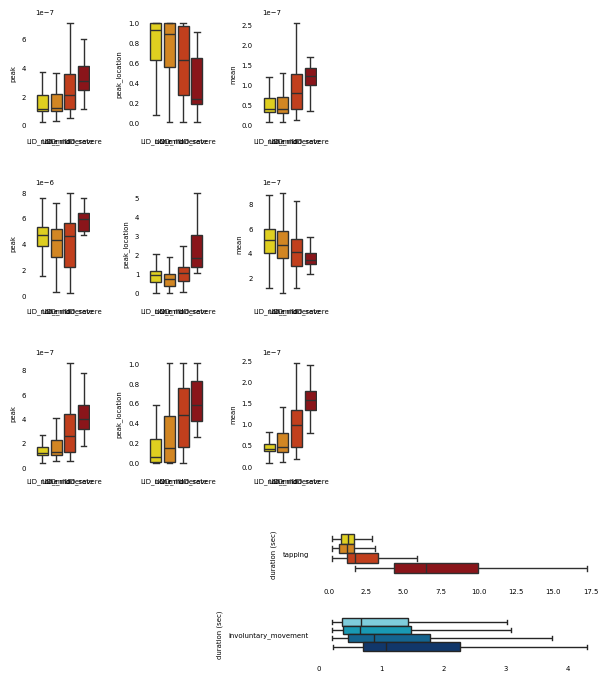

In [68]:
plt = utils_plotting_accelerometer.get_figure_template()

ax1  = plt.subplot2grid((75, 50), (0, 0), colspan=5, rowspan=13)
ax2  = plt.subplot2grid((75, 50), (0, 10), colspan=5, rowspan=13)
ax3  = plt.subplot2grid((75, 50), (0, 20), colspan=5, rowspan=13)

ax4  = plt.subplot2grid((75, 50), (20, 0), colspan=5, rowspan=13)
ax5  = plt.subplot2grid((75, 50), (20, 10), colspan=5, rowspan=13)
ax6  = plt.subplot2grid((75, 50), (20, 20), colspan=5, rowspan=13)

ax7  = plt.subplot2grid((75, 50), (40, 0), colspan=5, rowspan=13)
ax8  = plt.subplot2grid((75, 50), (40, 10), colspan=5, rowspan=13)
ax9  = plt.subplot2grid((75, 50), (40, 20), colspan=5, rowspan=13)

ax10 = plt.subplot2grid((75, 50), (60, 25), colspan=25, rowspan=6)
ax11 = plt.subplot2grid((75, 50), (70, 25), colspan=25, rowspan=6)

ax1 = boxplot(df_accelerometer_features[(df_accelerometer_features.event_category=="tapping") & (df_accelerometer_features.event_segment=="pre")],
              feat_x="dyskinesia_severity", feat_y="peak", hue="dyskinesia_severity", axis=ax1, 
              color_palette=colors_tapping, ylabel="peak")

ax2 = boxplot(df_accelerometer_features[(df_accelerometer_features.event_category=="tapping") & (df_accelerometer_features.event_segment=="pre")],
              feat_x="dyskinesia_severity", feat_y="peak_location", hue="dyskinesia_severity", axis=ax2, 
              color_palette=colors_tapping, ylabel="peak_location")

ax3 = boxplot(df_accelerometer_features[(df_accelerometer_features.event_category=="tapping") & (df_accelerometer_features.event_segment=="pre")],
              feat_x="dyskinesia_severity", feat_y="mean", hue="dyskinesia_severity", axis=ax3, 
              color_palette=colors_tapping, ylabel="mean")

ax4 = boxplot(df_accelerometer_features[(df_accelerometer_features.event_category=="tapping") & (df_accelerometer_features.event_segment=="event")],
              feat_x="dyskinesia_severity", feat_y="peak", hue="dyskinesia_severity", axis=ax4, 
              color_palette=colors_tapping, ylabel="peak")

ax5 = boxplot(df_accelerometer_features[(df_accelerometer_features.event_category=="tapping") & (df_accelerometer_features.event_segment=="event")],
              feat_x="dyskinesia_severity", feat_y="peak_location", hue="dyskinesia_severity", axis=ax5, 
              color_palette=colors_tapping, ylabel="peak_location")

ax6 = boxplot(df_accelerometer_features[(df_accelerometer_features.event_category=="tapping") & (df_accelerometer_features.event_segment=="event")],
              feat_x="dyskinesia_severity", feat_y="mean", hue="dyskinesia_severity", axis=ax6, 
              color_palette=colors_tapping, ylabel="mean")

ax7 = boxplot(df_accelerometer_features[(df_accelerometer_features.event_category=="tapping") & (df_accelerometer_features.event_segment=="post")],
              feat_x="dyskinesia_severity", feat_y="peak", hue="dyskinesia_severity", axis=ax7, 
              color_palette=colors_tapping, ylabel="peak")

ax8 = boxplot(df_accelerometer_features[(df_accelerometer_features.event_category=="tapping") & (df_accelerometer_features.event_segment=="post")],
              feat_x="dyskinesia_severity", feat_y="peak_location", hue="dyskinesia_severity", axis=ax8, 
              color_palette=colors_tapping, ylabel="peak_location")

ax9 = boxplot(df_accelerometer_features[(df_accelerometer_features.event_category=="tapping") & (df_accelerometer_features.event_segment=="post")],
              feat_x="dyskinesia_severity", feat_y="mean", hue="dyskinesia_severity", axis=ax9, 
              color_palette=colors_tapping, ylabel="mean")


ax10 = boxplot(df_accelerometer_events[df_accelerometer_events.event_category=="tapping"],
              feat_y="event_category", feat_x="duration", hue="dyskinesia_score", axis=ax10, 
              color_palette=colors_tapping, ylabel="duration (sec)")

ax11 = boxplot(df_accelerometer_events[df_accelerometer_events.event_category=="involuntary_movement"],
              feat_y="event_category", feat_x="duration", hue="dyskinesia_score", axis=ax11, 
              color_palette=colors_invol_m, ylabel="duration (sec)")

#ax3.set_xlim([0,20])
#ax4.set_xlim([0,20])

utils_plotting_accelerometer.set_axis(ax1)
utils_plotting_accelerometer.set_axis(ax2)
utils_plotting_accelerometer.set_axis(ax3)
utils_plotting_accelerometer.set_axis(ax4)
utils_plotting_accelerometer.set_axis(ax5)
utils_plotting_accelerometer.set_axis(ax6)
utils_plotting_accelerometer.set_axis(ax7)
utils_plotting_accelerometer.set_axis(ax8)
utils_plotting_accelerometer.set_axis(ax9)
utils_plotting_accelerometer.set_axis(ax10)
utils_plotting_accelerometer.set_axis(ax11)
plt.savefig("pff.svg", dpi=300)

In [ ]:
df_accelerometer_features